In [1]:
import pandas as pd
import numpy as np
import cv2,os
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

In [2]:
import pathlib

In [3]:
label_dict={"no_tumor":0,"glioma_tumor":1,"meningioma_tumor":2,"pituitary_tumor":3}
categories=["no_tumor","glioma_tumor","meningioma_tumor","pituitary_tumor"]
labels=[0,1,2,3]

In [4]:
train_data_path="btd_class/Training"
test_data_path="btd_class/Testing"
data_dir = "btd_class/Training"
data_dir=pathlib.Path(data_dir)

In [5]:
import matplotlib.pyplot as plt

In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Dense,Flatten,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [7]:
from tensorflow.keras.applications import InceptionResNetV2

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [16]:
Conv_Base = InceptionResNetV2(include_top = False, weights = 'imagenet', input_shape = (150,150, 3))

for layer in Conv_Base.layers[:-8]:
    layer.trainable = False

model = Sequential()
model.add(Conv_Base)
model.add(Flatten())
model.add(Dense(units = 256, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 4, activation = 'softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 3, 3, 1536)        54336736  
_________________________________________________________________
flatten_1 (Flatten)          (None, 13824)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               3539200   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 1028      
Total params: 57,876,964
Trainable params: 7,670,564
Non-trainable params: 50,206,400
_________________________________________________________________


In [17]:
batch_size = 48

Train_Datagen = ImageDataGenerator(dtype = 'float32', preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input,validation_split=0.12)
Val_Datagen = ImageDataGenerator(dtype = 'float32', preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input,validation_split=0.12)

train_gen = Train_Datagen.flow_from_directory(directory = train_data_path, target_size = (150,150), 
                                       batch_size = batch_size, class_mode = 'categorical',subset="training")

val_gen = Val_Datagen.flow_from_directory(directory = train_data_path, target_size = (150,150), 
                                       batch_size = batch_size, class_mode = 'categorical',subset="validation")

epochs = 10
Number_Of_Training_Images = train_gen.classes.shape[0]
steps_per_epoch = Number_Of_Training_Images/batch_size

model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

history = model.fit(train_gen, epochs = epochs, 
                    #batch_size = batch_size,
                    validation_data = val_gen, steps_per_epoch = steps_per_epoch)

Found 2527 images belonging to 4 classes.
Found 343 images belonging to 4 classes.
Epoch 1/10
53/52 [==============================] - 274s 5s/step - loss: 1.6347 - accuracy: 0.6810 - val_loss: 0.6357 - val_accuracy: 0.7697
Epoch 2/10
53/52 [==============================] - 273s 5s/step - loss: 0.4321 - accuracy: 0.8370 - val_loss: 0.5249 - val_accuracy: 0.8192
Epoch 3/10
53/52 [==============================] - 268s 5s/step - loss: 0.2890 - accuracy: 0.8932 - val_loss: 0.6062 - val_accuracy: 0.8105
Epoch 4/10
53/52 [==============================] - 269s 5s/step - loss: 0.2467 - accuracy: 0.9098 - val_loss: 0.5369 - val_accuracy: 0.8134
Epoch 5/10
53/52 [==============================] - 268s 5s/step - loss: 0.1728 - accuracy: 0.9375 - val_loss: 0.8201 - val_accuracy: 0.7988
Epoch 6/10
53/52 [==============================] - 271s 5s/step - loss: 0.1345 - accuracy: 0.9529 - val_loss: 0.7658 - val_accuracy: 0.8076
Epoch 7/10
53/52 [==============================] - 267s 5s/step - loss

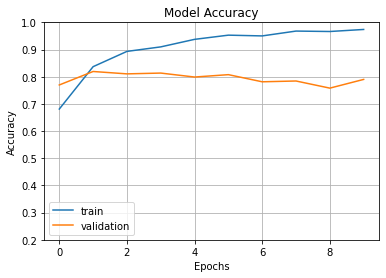

In [18]:
fig3 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.2,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.savefig('InceptionResNetAcc.png')
plt.legend(['train', 'validation'])
plt.show()

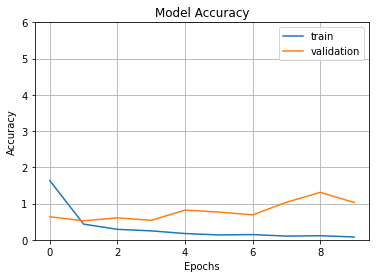

In [19]:
fig2 = plt.gcf()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.axis(ymin=0,ymax=6)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.savefig('InceptionResNetLoss.png')
plt.show()

In [29]:
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input)

In [30]:
test_data = test_datagen.flow_from_directory(
    test_data_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical')

Found 394 images belonging to 4 classes.


In [31]:
scoreSeg = model.evaluate(test_data)

13/13 [==============================] - 33s 3s/step - loss: 1.9085 - accuracy: 0.7741


In [50]:
Y_pred = model.predict(test_data, 394 // 32+1)
y_pred = np.argmax(Y_pred, axis=1)

In [51]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,roc_curve

In [52]:
print(confusion_matrix(test_data.classes, y_pred))


[[12 39 38 11]
 [12 51 32 20]
 [17 41 36 11]
 [ 4 41 17 12]]


In [53]:
print(classification_report(test_data.classes, y_pred, target_names=categories))

                  precision    recall  f1-score   support

        no_tumor       0.27      0.12      0.17       100
    glioma_tumor       0.30      0.44      0.36       115
meningioma_tumor       0.29      0.34      0.32       105
 pituitary_tumor       0.22      0.16      0.19        74

        accuracy                           0.28       394
       macro avg       0.27      0.27      0.26       394
    weighted avg       0.27      0.28      0.27       394

